In [ ]:
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import IPython.display as ipd

import os
import json
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import utils.vits.commons as commons
import utils.vits.utils as utils
from utils.vits.models import SynthesizerTrn
from utils.vits.text.symbols import symbols
from utils.vits.text import text_to_sequence

from scipy.io.wavfile import write
from utils.vits.utils import load_wav_to_torch, load_filepaths_and_text
from utils.vits.mel_processing import spectrogram_torch

import logging

matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)

import numba.core.byteflow

# Set the logging level of Numba's byteflow module to INFO or higher to suppress debug messages
numba_logger = logging.getLogger('numba.core.byteflow')
numba_logger.setLevel(logging.INFO)


def get_text(text, hps):
    text_norm = text_to_sequence(text, hps.data.text_cleaners)
    if hps.data.add_blank:
        text_norm = commons.intersperse(text_norm, 0)
    text_norm = torch.LongTensor(text_norm)
    return text_norm



In [2]:
hps = utils.get_hparams_from_file("../utils/vits/configs/ljs_base.json")
net_g = SynthesizerTrn(
    len(symbols),
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    **hps.model)
_ = net_g.eval()

_ = utils.load_checkpoint("../saved_models/pretrained_ljs.pth", net_g, None)

/home/xuanru/miniconda3/envs/whisperx/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


in_channels: 513


In [3]:
stn_tst = get_text("You wish to know all about my grandfather. Well, he is ninety years old. ", hps)
with torch.no_grad():
    x_tst = stn_tst.unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)])
    audio = net_g.infer(x_tst, x_tst_lengths, noise_scale=.667, noise_scale_w=0.8, length_scale=1)[0][0,0].data.float().numpy()
ipd.display(ipd.Audio(audio, rate=hps.data.sampling_rate))

# Aligner

In [4]:
# check sr
import wave

def get_sample_rate_wave(audio_file_path):
    with wave.open(audio_file_path, 'rb') as wf:
        return wf.getframerate()


audio_file_path = "../vctk-tts/disfluent_audio/p001_001_block.wav" 
sample_rate = get_sample_rate_wave(audio_file_path)
print(f"Sample rate of {audio_file_path} is {sample_rate} Hz")

Sample rate of ../vctk-tts/disfluent_audio/p001_001_block.wav is 22050 Hz


Please call Stella.
22050
audio shape:  torch.Size([51968])
max auido norm before is 32767.0
max auido norm is 0.999969482421875
audio norm shape torch.Size([1, 51968])
spec shape is torch.Size([1, 513, 203])


/home/xuanru/miniconda3/envs/whisperx/lib/python3.10/site-packages/torch/functional.py:660: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:874.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


2
neg_cent shape:  torch.Size([1, 203, 41])


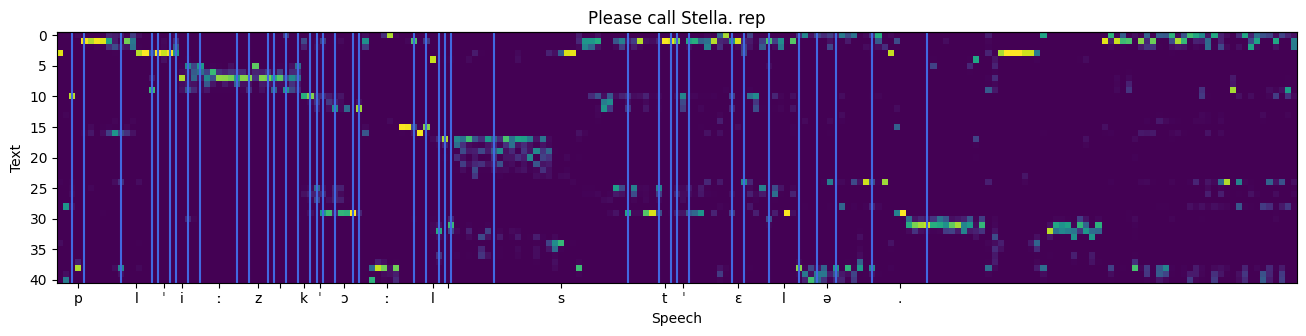

In [ ]:
import json

import matplotlib.pyplot as plt

def get_audio_a(filename):
    _sampling_rate = 22050 ####
    _max_wav_value = 32768.0
    _filter_length = 1024
    _hop_length = 256
    _win_length = 1024

    audio, sampling_rate = load_wav_to_torch(filename)
    
    # print(sampling_rate)
    if sampling_rate != _sampling_rate:
        print("{} SR doesn't match target {} SR".format(
            sampling_rate, _sampling_rate))
        print("resampling to {} SR...".format(_sampling_rate))
        resampler=torchaudio.transforms.Resample(orig_freq=sampling_rate,new_freq=_sampling_rate)
        audio=resampler(audio)
    #flatten to 1 channel
    print(audio.shape)
    if audio.shape[0]>1:
        audio=audio.squeeze()
    
    print("audio shape: ", audio.shape)
        
    # Normalize the waveform between -1.0 and 1.0
    normalized_waveform = audio / torch.max(torch.abs(audio))

    # Scale the normalized waveform to the range of a 16-bit audio
    audio = normalized_waveform * 32767   # 2^15
    print(f"max auido norm before is {torch.max(audio)}")
    audio_norm = audio / _max_wav_value
    print(f"max auido norm is {torch.max(audio_norm)}")
    audio_norm = audio_norm.unsqueeze(0)
    spec_filename = filename.replace(".wav", ".spec.pt")
    print("audio norm shape", audio_norm.shape)
    spec = spectrogram_torch(audio_norm, _filter_length,
        _sampling_rate, _hop_length, _win_length,
        center=False)
    print(f"spec shape is {spec.shape}")
    spec = torch.squeeze(spec, 0)
    torch.save(spec, spec_filename)  # save spec
    return spec, audio_norm


def get_labels(path):
    with open(path, "r") as f:
        labels = json.load(f)
    
    phonemes = labels[0]["phonemes"]
    text_path = path.replace("disfluent_labels", "gt_text")
    last = text_path.rfind('_')
    text_path = text_path[:last] + ".txt"
    with open(text_path, 'r') as file:
        text = file.read()

    # text = labels[0]["text"]

    for w in phonemes:
        w["start"] = int(w["start"] / 0.016)
        w["end"] = int(w["end"] / 0.016) 
    
    return phonemes, text

def get_audio(path="../vctk-tts/disfluent_audio/p001_001_rep.wav"):
    spec, wav = get_audio_a(path) #[spec is 1, d, t]

    return spec, wav 

def process_audio(spec, wav, _text):

    stn_tst = get_text(_text, hps)
    # stn_tst = get_text("knows both he them", hps)
    # stn_tst = get_text("I miss you", hps)
    x_tst = stn_tst.unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)])
    
    y = spec.unsqueeze(0)
    y_lengths = torch.LongTensor([y.shape[-1]])
    t = net_g(x_tst, x_tst_lengths, y, y_lengths) 
    print(len(t[2]))
    o, l_length, (neg_cent, attn), ids_slice, x_mask, y_mask, (z, z_p, m_p, logs_p, m_q, logs_q) = net_g(x_tst, x_tst_lengths, y, y_lengths) #phoneme, mel_spec respectively

    print("neg_cent shape: ", neg_cent.shape)

    neg_cent = neg_cent.squeeze(0)

    neg_cent = nn.functional.softmax(neg_cent, dim=1)

    return neg_cent

def plot_attention(neg_cent, phonemes, _text, disfluency_type):

    fig, ax = plt.subplots(figsize=(16, 8))

    ax_t = ax.secondary_xaxis('top')

    # plt.colorbar(im,fraction=0.0046)
    # fig.set_figheight(8)
    # fig.set_figwidth(16)
    plt.xlabel('Speech')
    plt.ylabel('Text')
    plt.title(f'{_text}')

    x_ticks = [(w["start"] + w["end"]) / 2 for w in phonemes if w["phoneme"] and "actual" not in w["phoneme"]]
    x_labels = [w["phoneme"] for w in phonemes if w["phoneme"] and "actual" not in w["phoneme"]]
    ax.set_xticks(x_ticks, x_labels)

    x_top_ticks = [(w["start"] + w["end"]) / 2 for w in phonemes if w["phoneme"] and "actual" in w["phoneme"]]
    x_top_labels = [w["phoneme"] for w in phonemes if w["phoneme"] and "actual" in w["phoneme"]]
    ax_t.set_xticks(x_top_ticks, x_top_labels)
    for w in phonemes:
        color = "forestgreen" if w["phoneme"] and "actual" in w["phoneme"] else "royalblue"
        plt.axvline(x=w["start"], color=color)
        plt.axvline(x=w["end"], color=color)

    plt.imshow(neg_cent.transpose(-1, -2), cmap='viridis', interpolation='nearest')

    plt.xlabel('Speech')
    plt.ylabel('Text')
    plt.title(f'{_text} {disfluency_type}')
    plt.show()

vctk_file = "p001_001"
folder = "disfluent"
disfluency_type = "rep"
raw_labels = f"../vctk-tts/{folder}_labels/{vctk_file}_{disfluency_type}.json"
raw_audio = f"../vctk-tts/{folder}_audio/{vctk_file}_{disfluency_type}.wav"

phonemes, text = get_labels(raw_labels)
print(text)
spec, wav = get_audio(raw_audio)
neg_cent = process_audio(spec, wav, text)

plot_attention(neg_cent, phonemes, text, disfluency_type)


In [6]:
import os
import sys
import importlib
importlib.reload(utils)
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
from torch.nn.utils.rnn import pad_sequence
from utils.model_utils.conv1d_transformer import Conv1DTransformerDecoder

from utils.model_utils.dataset_5 import Dataset
# from utils.model_utils.dataset_emap import Dataset

from tqdm import tqdm
import matplotlib.pyplot as plt

def collate_fn(batch):
    texts = []
    text_lengths = []
    specs = []
    spec_lengths = []
    label_matrices = []
    num_regions = []
    region = []
    start_region = []
    end_region = []
    files = []
    for sample in batch:
        texts += [sample[0]]
        text_lengths += [sample[1]]
        specs += [torch.transpose(sample[2], 0, 1)]
        spec_lengths += [sample[3]]
        label_matrices += [sample[4]]
        num_regions += [sample[5]]
        region += [sample[6]]
        start_region += [sample[7]]
        end_region += [sample[8]]
        files += [sample[9]]

    return (
        pad_sequence(texts, batch_first=True),
        torch.tensor(text_lengths),
        torch.transpose(pad_sequence(specs, batch_first=True), -1, -2),
        torch.tensor(spec_lengths),
        pad_sequence(label_matrices, batch_first=True),
        torch.tensor(num_regions),
        torch.tensor(region),
        torch.tensor(start_region),
        torch.tensor(end_region),
        files
    )
def get_soft_attention(hps, net_g, text, text_lengths, spec, spec_lengths):
    with torch.no_grad():
        o, l_length, (neg_cent, attn), ids_slice, x_mask, y_mask, (z, z_p, m_p, logs_p, m_q, logs_q) = net_g(text, text_lengths, spec, spec_lengths)  # phoneme, mel_spec respectively

        neg_cent = nn.functional.softmax(neg_cent, dim=-1)

    return neg_cent

## Test classification accuracy

Cleaning data...
Cross-checking with gt text...
Loading sample filenames...


100%|██████████| 180/180 [00:00<00:00, 1537626.72it/s]


180


100%|██████████| 3/3 [00:38<00:00, 12.92s/it]

Validation reptition Exists Accuracy: 0.8351049224535624
Validation reptition Type Accuracy: 0.7350833415985107
Validation reptition Bound Loss: 0.047225531190633774
------------------------------
Validation block Exists Accuracy: 0.8429925441741943
Validation block Type Accuracy: 1.0
Validation block Bound Loss: 0.08336641639471054
------------------------------
Validation missing Exists Accuracy: 0.8248322407404581
Validation missing Type Accuracy: 0.5505827565987905
Validation missing Bound Loss: 0.0009210439360079666
------------------------------
Validation replace Exists Accuracy: 0.8245192368825277
Validation replace Type Accuracy: 0.7744108041127523
Validation replace Bound Loss: 0.000934796097377936
------------------------------
Validation prolong Exists Accuracy: 0.8309294978777567
Validation prolong Type Accuracy: 0.9152421752611796
Validation prolong Bound Loss: 0.04957705611983935
------------------------------
0.0012176863383501768


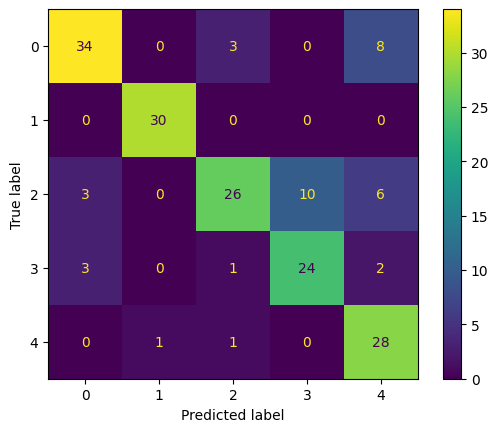

In [7]:
import os
import sys
import importlib
importlib.reload(utils)
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.nn.utils.rnn import pad_sequence
from utils.model_utils.conv1d_transformer import Conv1DTransformerDecoder

# from utils.model_utils.dataset_other import Dataset
from utils.model_utils.dataset_other_mel import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import warnings
warnings.filterwarnings('ignore')

text_channels = 768
kernel_size= 3
kernel_stride = 1
num_blocks = 4
num_classes = 5   ## change
downsample_factor = 16  #8
n_heads = 8
n_layers = 8

# device = torch.device("cpu")
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

# decoder = Decoder(in_channels, out_channels, kernel_size, kernel_stride, num_blocks, num_classes, downsample_factor)

decoder = torch.load("../saved_models/decoder_tts_new_l", map_location=device)
decoder.train()
torch.manual_seed(0)

dataset = Dataset(
    "../vctk-tts", hps, downsample_factor, skip_raw_label_comparison=True
)
train_set, val_set = torch.utils.data.random_split(dataset, [0, 1])

print(len(val_set))
val_loader = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)
labels = ["rep", "block", "missing", "replace", "prolong"]
label_name = ["reptition", "block", "missing", "replace", "prolong"]

num_types = 5  # Assuming there are 4 types of dysfluency
train_type_specific_metrics = {
    'exists_accuracy': np.zeros(num_types),
    'type_accuracy': np.zeros(num_types),
    'bound_loss': np.zeros(num_types),
}

val_type_specific_metrics = {
    'exists_accuracy': np.zeros(num_types),
    'type_accuracy': np.zeros(num_types),
    'bound_loss': np.zeros(num_types),
}

pred, labels = [], []

net_g = net_g.to(device)

val_disfluency_type_accuracy = []
val_disfluency_exists_accuracy = []
b_bound_loss = []

bound_loss = nn.MSELoss()

for (
    text,
    text_length,
    spec,
    spec_length,
    label_matrix,
    num_regions,
    region,
    start_region,
    end_region,
    _
) in tqdm(val_loader):
    text = text.to(device)
    text_length = text_length.to(device)
    spec = spec.to(device)
    spec_length = spec_length.to(device)
    label_matrix = label_matrix.to(device)

    # print("label matrix:", label_matrix)

    soft_attention = get_soft_attention(
        hps, net_g, text, text_length, spec, spec_length
    )  # dims - batch_size, speech_temporal_dim, text_temporal_dim/feature_dim

    # max feature dim size of 1024
    soft_attention = nn.functional.pad(
        soft_attention,
        (
            0,
            768 - soft_attention.shape[-1],
            0,
            1024 - soft_attention.shape[-2],
        ),
    )

    label_matrix = nn.functional.pad(
        label_matrix,
        (
            0,
            0,
            0,
            64 - label_matrix.shape[-2],
        ),
    )

    # seq length
    mask = torch.ones((label_matrix.shape[0], 64), dtype=torch.bool)
    for i in range(label_matrix.shape[0]):
        mask[i, : num_regions[i] + 1] = False

    # temp unsqueeze for unbatched inputs
    output = decoder(soft_attention, mask.to(device))

    exists_labels = label_matrix[:, :, 2]
    # print("exists: {}".format(exists_labels))
    exists_mask = exists_labels > 0
    disfluency_type_pred, disfluency_type_labels = (
        output[:, :, 3:],
        label_matrix[:, :, 3:],
    )

    disfluency_type_pred = disfluency_type_pred[exists_mask]
    disfluency_type_labels = disfluency_type_labels[exists_mask]

    type_pred_softmax = torch.log_softmax(disfluency_type_pred, dim=-1)
    _, y_pred_labels = torch.max(type_pred_softmax, dim=-1)
    _, disfluency_type_labels = torch.max(disfluency_type_labels, dim=-1)
    correct_type_pred = y_pred_labels == disfluency_type_labels
    type_acc = correct_type_pred.sum() / len(correct_type_pred)
    type_acc = torch.round(type_acc * 100)
    val_disfluency_type_accuracy += [type_acc.cpu()]

    curr_exists_accuracy = 0
    for i in range(label_matrix.shape[0]):
        exists_pred = torch.clamp(output[i, : num_regions[i], 2], 0, 1)
        exists_pred_tags = (exists_pred > 0.5).float()
        correct_exists_pred = (
            exists_pred_tags == exists_labels[i, : num_regions[i]]
        )
        exists_acc = correct_exists_pred.sum() / (len(correct_exists_pred))
        exists_acc = torch.round(exists_acc * 100)
        curr_exists_accuracy += exists_acc

    val_disfluency_exists_accuracy += [
        (curr_exists_accuracy / label_matrix.shape[0]).cpu()
    ]
    
    for type_idx in range(num_types):
        type_exists = label_matrix[:, :, 3 + type_idx] == 1  ### bool
        type_correct = (output[:, :, 2] > 0.5) == type_exists

        val_type_specific_metrics['exists_accuracy'][type_idx] += torch.mean(type_correct.float()).item()
        
        type_labels = label_matrix[type_exists]
        type_labels = type_labels[:, 3:]
        # print("type_labels: " + str(type_labels.shape))
        type_output = output[type_exists]
        type_output = type_output[:, 3:]
        # print("type_output: " + str(type_output.shape))

        _, type_predictions = torch.max(type_output, dim=-1)
        _, type_true = torch.max(type_labels, dim=-1)

        val_type_specific_metrics['type_accuracy'][type_idx] += torch.mean((type_predictions == type_true).float()).item()

        a, b= output[type_exists], label_matrix[type_exists]
        a, b= a[:, :2], b[:, :2]
        val_type_specific_metrics['bound_loss'][type_idx] += bound_loss(a, b).mean().item()


    a_bound_loss = 0
    for i in range(label_matrix.shape[0]): # batch_size
        main_region = label_matrix[i][region[i]]
        main_output = output[i][region[i]]

        # loss computations
        a_bound_loss += bound_loss(main_output[:2], main_region[:2])
         
        disfluency_type_pred, disfluency_type_labels = (
            output[i, region[i], 3:],
            label_matrix[i, region[i], 3:],
        )
        type_pred_softmax = torch.log_softmax(disfluency_type_pred, dim=-1)
        _, y_pred_labels = torch.max(type_pred_softmax, dim=-1)
        _, disfluency_type_labels = torch.max(disfluency_type_labels, dim=-1)

        pred.extend(list([y_pred_labels.cpu().numpy()]))
        labels.extend(list([disfluency_type_labels.cpu().numpy()]))
    
    a_bound_loss /= label_matrix.shape[0]
    b_bound_loss += [a_bound_loss.item()]

# Normalizing type-specific val metrics
for metric in val_type_specific_metrics:
    val_type_specific_metrics[metric] /= len(val_loader)

for type_idx in range(num_types): 
    print(f"Validation {label_name[type_idx]} Exists Accuracy: {val_type_specific_metrics['exists_accuracy'][type_idx]}")
    print(f"Validation {label_name[type_idx]} Type Accuracy: {val_type_specific_metrics['type_accuracy'][type_idx]}")
    print(f"Validation {label_name[type_idx]} Bound Loss: {val_type_specific_metrics['bound_loss'][type_idx]}")
    print("------------------------------")

print(np.mean(np.array(b_bound_loss)))
cm = confusion_matrix(labels, pred, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot()
plt.show()

## Test Decoder

In [8]:
import librosa

def plot_attention(neg_cent, words, _text, disfluency_type):

    fig, ax = plt.subplots(figsize=(16, 8))

    ax_t = ax.secondary_xaxis('top')

    # plt.colorbar(im,fraction=0.0046)
    # fig.set_figheight(8)
    # fig.set_figwidth(16)

    x_ticks = [(w["start"] + w["end"]) / 2 for w in words if w["phoneme"] and "actual" not in w["phoneme"]]
    x_labels = [w["phoneme"] for w in words if w["phoneme"] and "actual" not in w["phoneme"]]
    ax.set_xticks(x_ticks, x_labels)
    ax.tick_params(labelsize=40)

    x_top_ticks = [(w["start"] + w["end"]) / 2 for w in words if w["phoneme"] and "actual" in w["phoneme"]]
    x_top_labels = [w["phoneme"] for w in words if w["phoneme"] and "actual" in w["phoneme"]]
    ax_t.set_xticks(x_top_ticks, x_top_labels)
    ax_t.tick_params(labelsize=40)
    for w in words:
        color = "red" if w["phoneme"] and "actual" in w["phoneme"] else "white"
        plt.axvline(x=w["start"], color=color, lw=5)
        plt.axvline(x=w["end"], color=color, lw=5)

    plt.yticks([])
    plt.imshow(librosa.power_to_db(neg_cent.transpose(-1, -2)), aspect="auto", origin="lower", interpolation='none')
    plt.savefig("neg_cent_repetition.png")
    plt.show()



In [9]:
import torchaudio
import torchaudio.transforms as T

def out_spec(audio_file):

    # Load audio file and forced alignment
    
    y, sr = torchaudio.load(audio_file)
    
    n_fft = 1024
    win_length = None
    hop_length = 256  #16ms per frame

    # define transformation
    spectrogram = T.Spectrogram(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
    )

#     y = torch.FloatTensor(y).unsqueeze(0)
    # Perform transformation
    spec = spectrogram(y)

    return spec[0]

Cleaning data...
Cross-checking with gt text...
Loading sample filenames...


100%|██████████| 180/180 [00:00<00:00, 1343371.39it/s]


180


  0%|          | 0/180 [00:00<?, ?it/s]

['../vctk-tts/disfluent_audio/p003_010_prolong.wav']


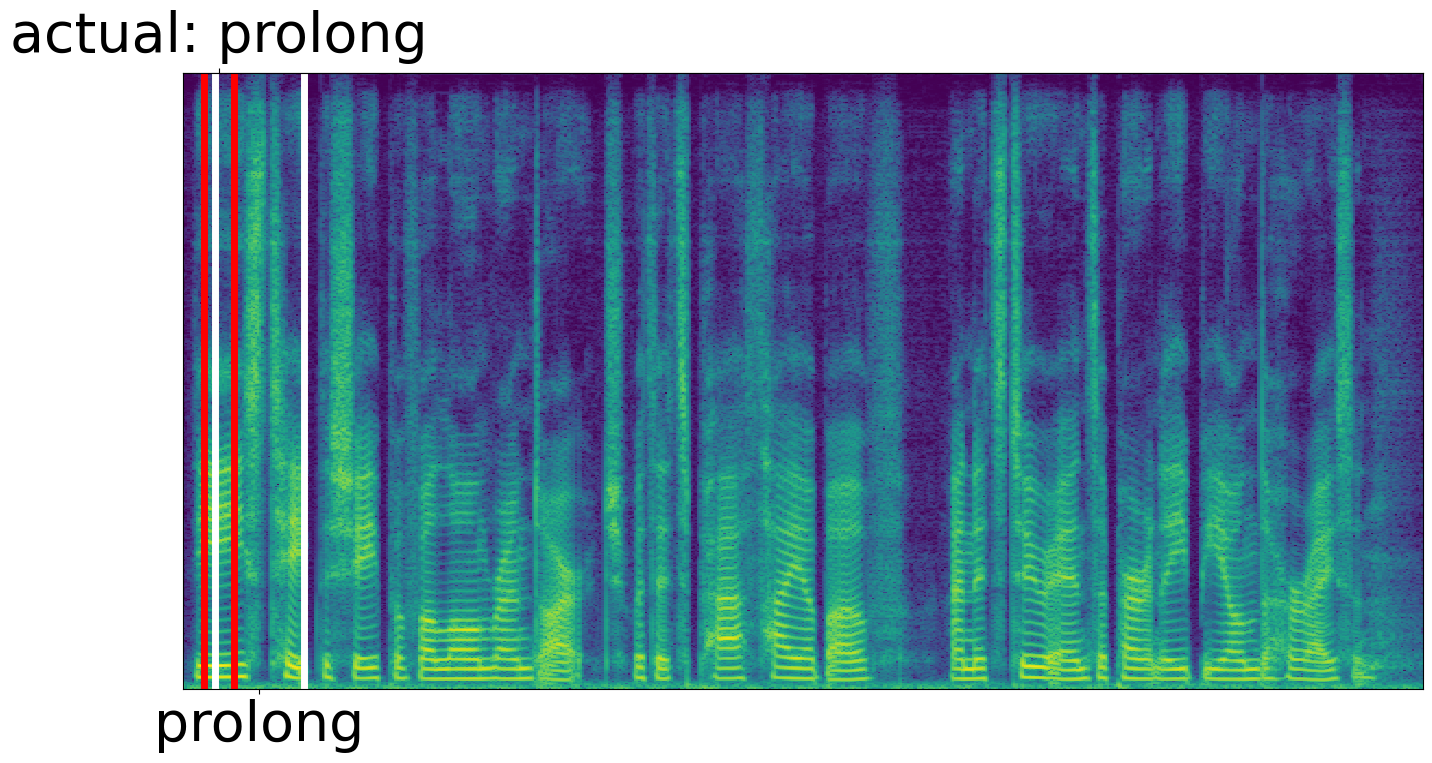

  1%|          | 1/180 [00:01<04:30,  1.51s/it]

['../vctk-tts/disfluent_audio/p001_002_rep.wav']


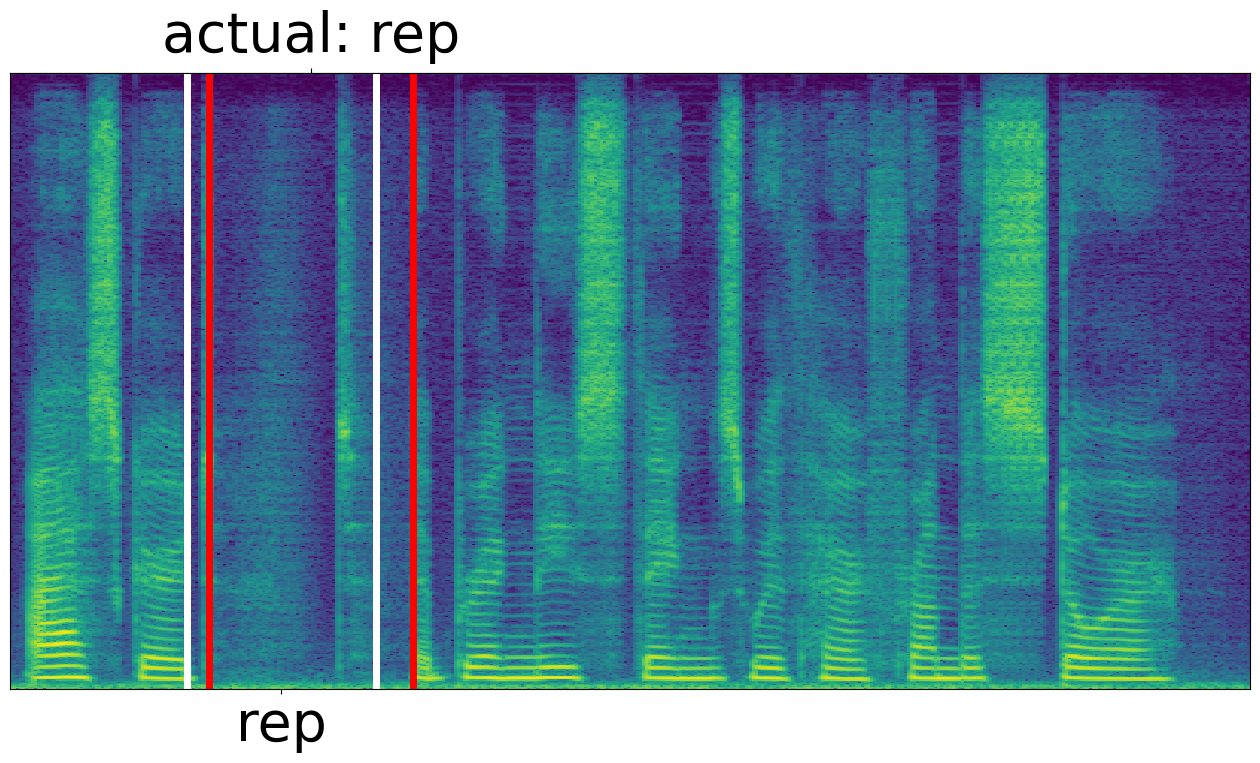

  1%|          | 2/180 [00:02<03:08,  1.06s/it]

['../vctk-tts/disfluent_audio/p003_006_prolong.wav']


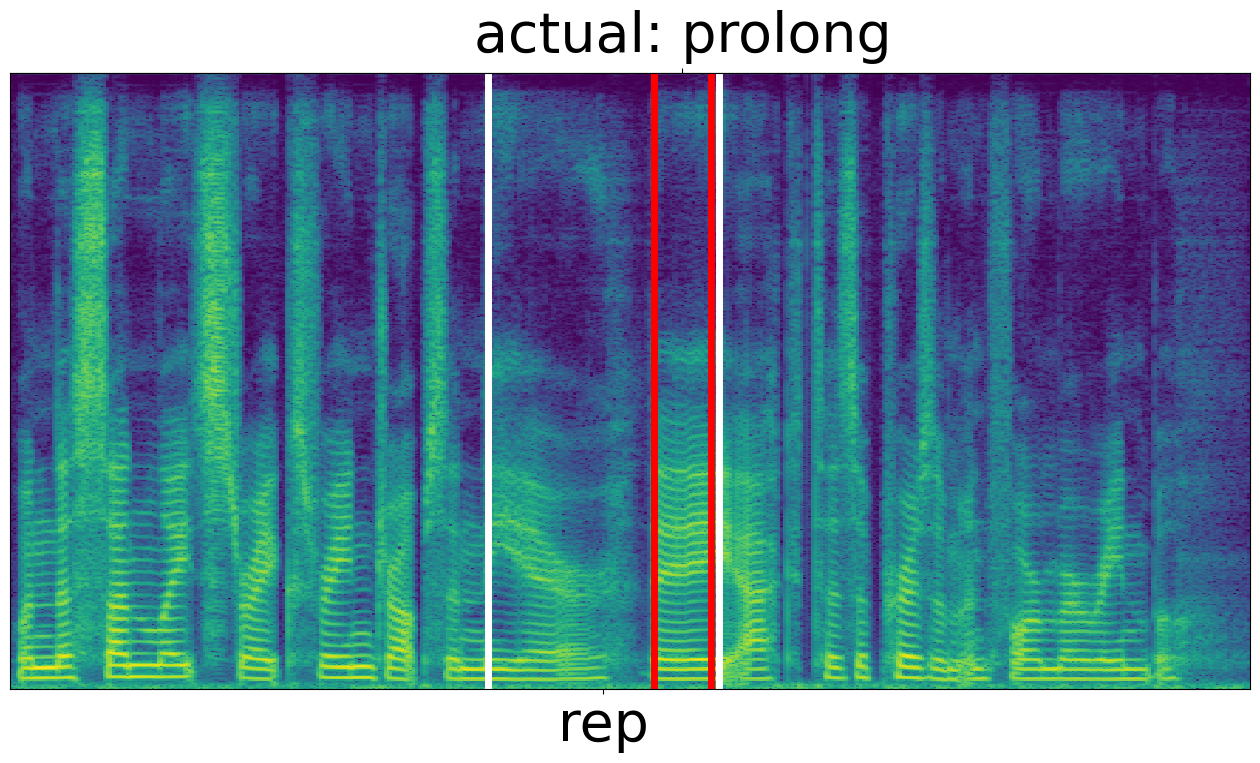

  2%|▏         | 3/180 [00:03<02:43,  1.08it/s]

['../vctk-tts/disfluent_audio/p001_009_prolong.wav']


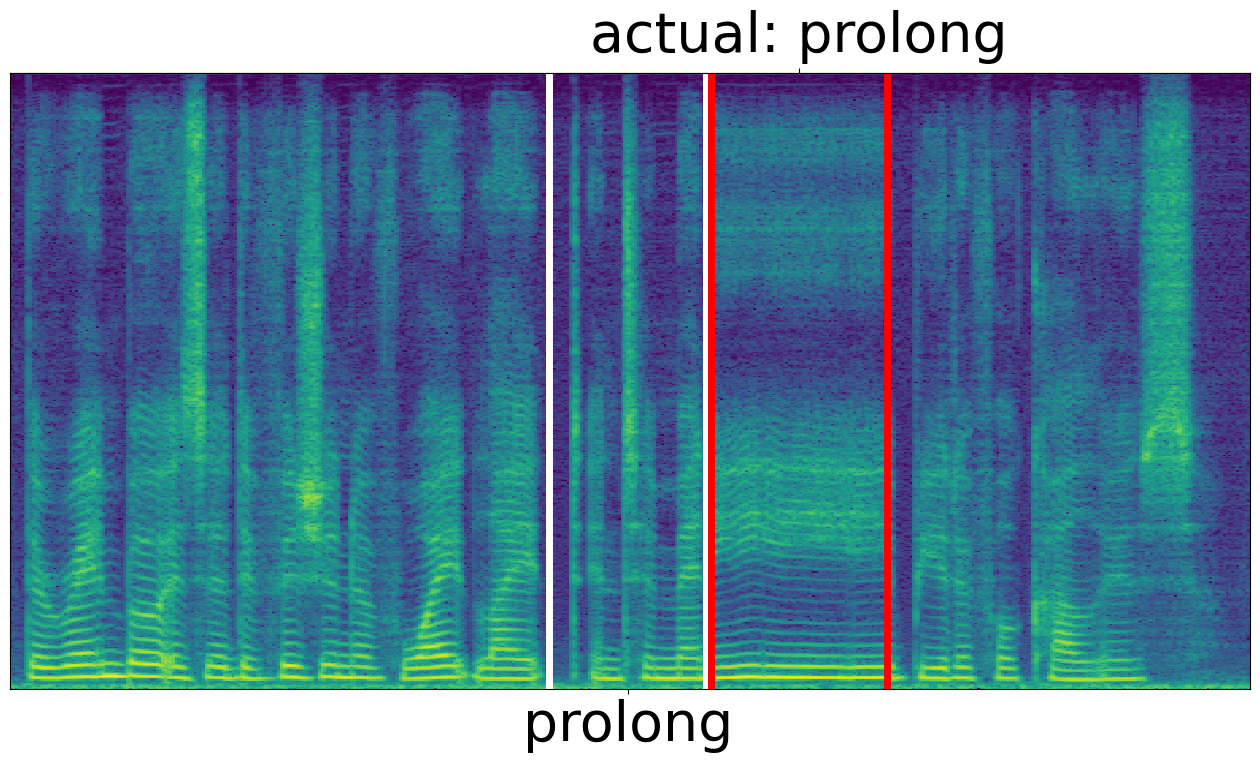

  2%|▏         | 4/180 [00:03<02:31,  1.16it/s]

['../vctk-tts/disfluent_audio/p002_008_replace.wav']


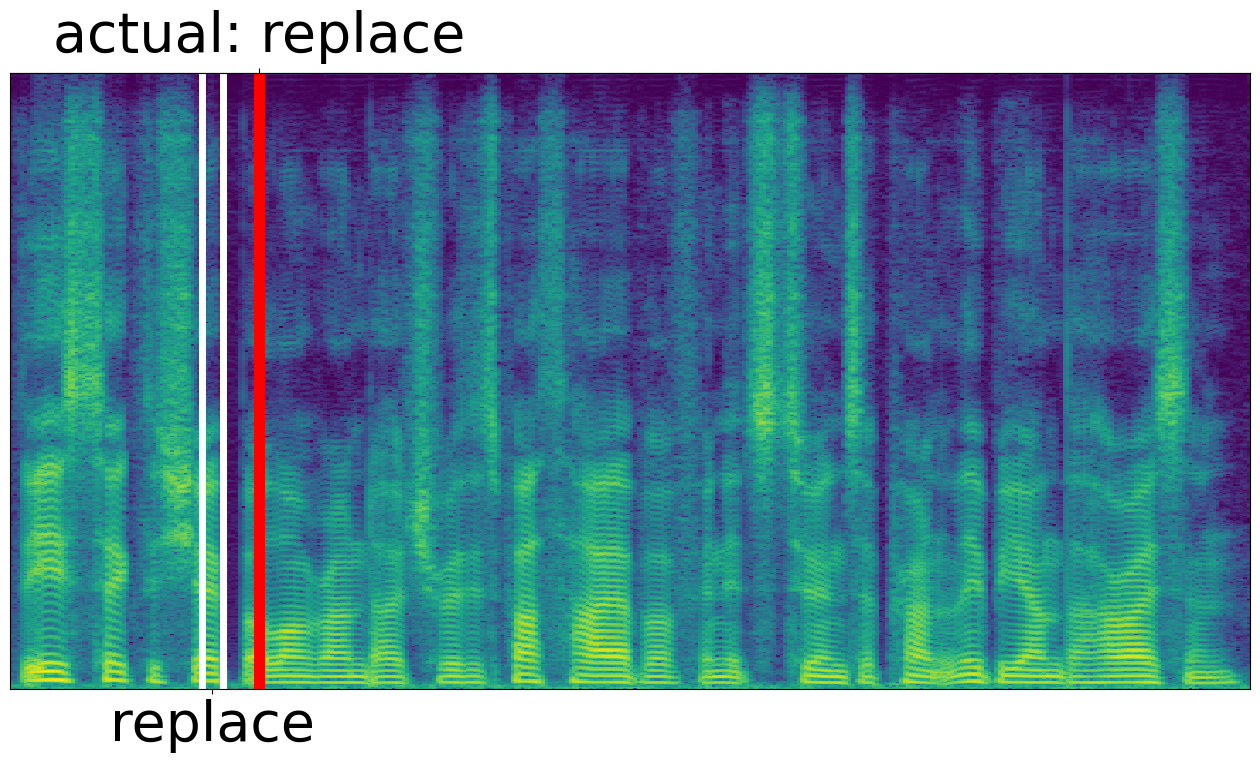

  3%|▎         | 5/180 [00:04<02:22,  1.23it/s]

['../vctk-tts/disfluent_audio/p001_006_prolong.wav']


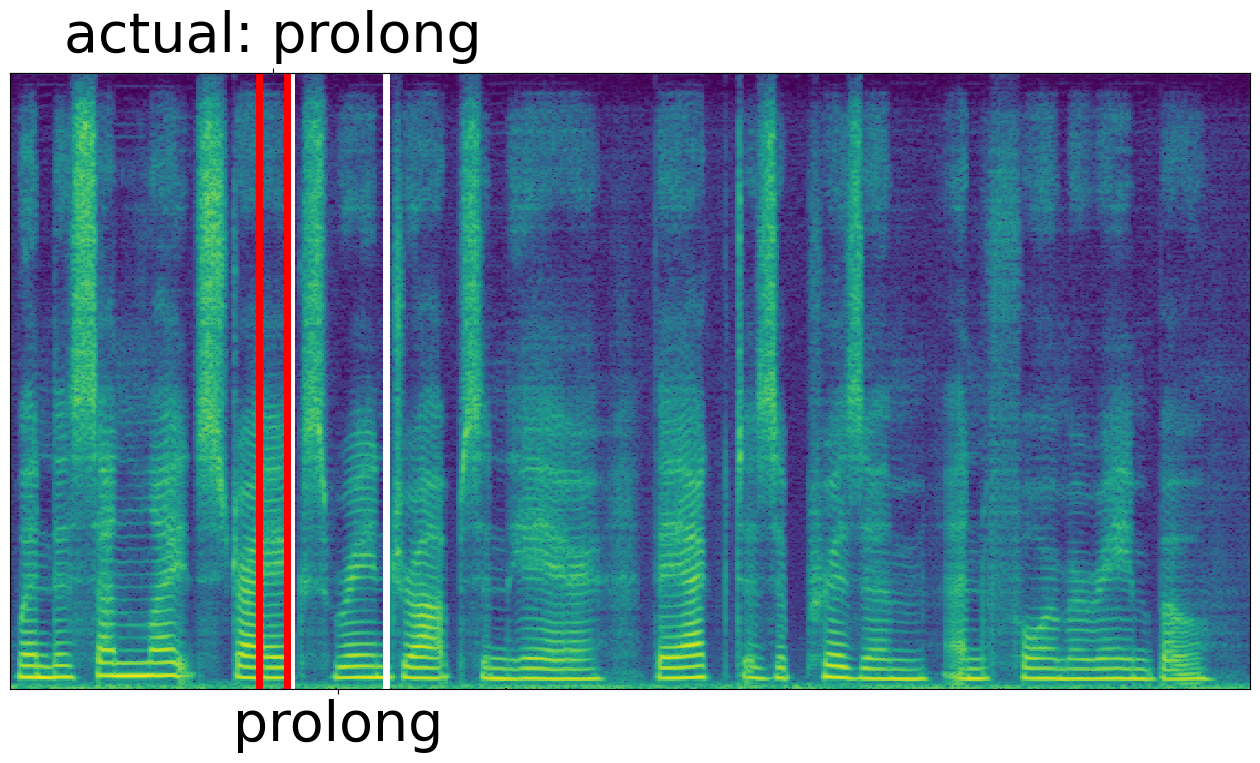

  3%|▎         | 5/180 [00:05<03:07,  1.07s/it]


In [10]:
import os
import sys
import importlib
importlib.reload(utils)
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
from torch.nn.utils.rnn import pad_sequence
from utils.model_utils.conv1d_transformer import Conv1DTransformerDecoder

from utils.model_utils.dataset_other_mel import Dataset
from tqdm import tqdm

device = torch.device("cuda:0")

# decoder = Decoder(in_channels, out_channels, kernel_size, kernel_stride, num_blocks, num_classes, downsample_factor)

decoder = torch.load("../saved_models/decoder_tts_joint", map_location=device)
dataset = Dataset(
    "../vctk-tts", hps, downsample_factor, skip_raw_label_comparison=True
)
train_set, val_set = torch.utils.data.random_split(dataset, [0, 1])

print(len(val_set))
val_loader = DataLoader(val_set, batch_size=1, shuffle=False, collate_fn=collate_fn)
labels = ["rep", "block", "missing", "replace", "prolong"]

net_g = net_g.to(device)

for _, (
    text,
    text_length,
    spec,
    spec_length,
    label_matrix,
    num_regions,
    region,
    start_region,
    end_region,
    file_paths
) in enumerate(tqdm(val_loader)):
    print(file_paths)
    text = text.to(device)
    text_length = text_length.to(device)
    spec = spec.to(device)
    spec_length = spec_length.to(device)
    label_matrix = label_matrix.to(device)

    soft_attention = get_soft_attention(
        hps, net_g, text, text_length, spec, spec_length
    )  # dims - batch_size, speech_temporal_dim, text_temporal_dim/feature_dim

    orig_text_dim_shape = soft_attention.shape[-1]

    # max feature dim size of 1024
    new_soft_attention = nn.functional.pad(
        soft_attention,
        (
            0,
            768 - soft_attention.shape[-1],
            0,
            1024 - soft_attention.shape[-2],
        ),
    )

    label_matrix = nn.functional.pad(
        label_matrix,
        (
            0,
            0,
            0,
            64 - label_matrix.shape[-2],
        ),
    )

    # seq length
    mask = torch.ones((label_matrix.shape[0], 64), dtype=torch.bool)
    for i in range(label_matrix.shape[0]):
        mask[i, : num_regions[i] + 1] = False

    # for doing batch size of 1
    output = decoder(new_soft_attention, mask.to(device))

    # print(label_matrix.shape)

    disf_out = torch.zeros((label_matrix.shape[0], 2, label_matrix.shape[-1]))

    disf_labels = torch.zeros((label_matrix.shape[0], 2, label_matrix.shape[-1]))


    disf_out[i] = torch.cat((output[i][region[i]].unsqueeze(0), output[i][region[i]].unsqueeze(0)), dim=-2)

    disf_labels[i] = torch.cat((label_matrix[i][region[i]].unsqueeze(0), label_matrix[i][region[i]].unsqueeze(0)), dim=-2)

    disfluency_type_pred, disfluency_type_labels = disf_out[:, :, 3:], disf_labels[:, :, 3:]
    type_pred_softmax = torch.log_softmax(disfluency_type_pred, dim=-1)
    a, y_pred_labels = torch.max(type_pred_softmax, dim=-1)
    a, disfluency_type_labels = torch.max(disfluency_type_labels, dim=-1)

    disfluency_bound_pred, disfluency_bound_labels = disf_out[:, :, :2], disf_labels[:, :, :2]
    # print("bounds: ", disfluency_bound_pred.shape, disfluency_bound_labels)
    disfluency_bound_pred = disfluency_bound_pred.squeeze(0)
    disfluency_bound_labels = disfluency_bound_labels.squeeze(0)

    # print("type labels: ", disfluency_type_labels, disfluency_type_labels.shape)

    disf_words_pred = []
    disf_words_label = []
    bounds_pred = disfluency_bound_pred[0] * 1024
    bounds_labels = disfluency_bound_labels[0] * 1024
    disf_words_pred.append({"start": bounds_pred[0].item(), "end": bounds_pred[1].item(), "phoneme": labels[y_pred_labels[0][i].item()]})
    disf_words_label.append({"start": bounds_labels[0].item(), "end": bounds_labels[1].item(), "phoneme": f"actual: {labels[disfluency_type_labels[0][i].item()]}"})

    disf_words_pred.extend(disf_words_label)
    plot_attention(torch.transpose(spec, -1, -2).cpu().squeeze(0), disf_words_pred, "", 0)

    if _ % 5 == 0 and _ != 0:
        break